In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

from lib import dpf, panda_models, panda_datasets
from lib.utils import file_utils, torch_utils, misc_utils

print(torch.__version__, np.__version__)

1.3.1 1.16.4


In [4]:
# Create model & training buddy
#experiment_name = "push_pull_no_prev"
experiment_name = "alt_model"

dynamics_model = panda_models.PandaAltDynamicsModel(units=32)
measurement_model = panda_models.PandaMeasurementModel(units=32)

pf_model = dpf.ParticleFilterNetwork(dynamics_model, measurement_model)

buddy = torch_utils.TrainingBuddy(
    experiment_name,
    pf_model,
    optimizer_names=["e2e", "dynamics", "measurement"],
    log_dir="logs/pf",
    checkpoint_dir="checkpoints/pf"
)

Using device: cuda
No checkpoint found


In [5]:
dynamics_trainset = panda_datasets.PandaSimpleDataset(
    "data/pull-test-tiny.hdf5",
    #"data/push-test-small.hdf5",
    use_proprioception=True,
    use_vision=True,
    vision_interval=1
)
dynamics_trainset_loader = torch.utils.data.DataLoader(dynamics_trainset, batch_size=64, shuffle=True, num_workers=2)

Parsed data: 199 active, 0 inactive
Keeping: 0


In [6]:
# Train dynamics only
def train_dynamics(dynamics_model, log_interval=10):
    # Train for 1 epoch
    for batch_idx, batch in enumerate(dynamics_trainset_loader):
        # Transfer to GPU and pull out batch data
        batch_gpu = torch_utils.to_device(batch, buddy._device)
        prev_states, unused_observations, controls, new_states = batch_gpu

        #prev_states += torch_utils.to_torch(np.random.normal(0, 0.01, size=prev_states.shape), device=buddy._device)
        prev_states = prev_states[:,np.newaxis,:]
        new_states_pred = dynamics_model(prev_states, controls, noisy=False)
        new_states_pred = new_states_pred.squeeze(dim=1)
        
        
        mse_pos, mse_vel = torch.mean((new_states_pred - new_states) ** 2, axis=0)
        loss = (mse_pos + mse_vel) / 2

        buddy.minimize(loss, optimizer_name="dynamics")
        
        if buddy._steps % log_interval == 0:
            buddy.log("dynamics/training loss", loss)
            buddy.log("dynamics/MSE position", mse_pos)
            buddy.log("dynamics/MSE velocity", mse_vel)

            label_std = new_states.std(dim=0)
            assert label_std.shape == (2,)
            buddy.log("dynamics/Label pos std", label_std[0])
            buddy.log("dynamics/Label vel std", label_std[1])

            pred_std = new_states_pred.std(dim=0)
            assert pred_std.shape == (2,)
            buddy.log("dynamics/Predicted pos std", pred_std[0])
            buddy.log("dynamics/Predicted vel std", pred_std[1])

            label_mean = new_states.mean(dim=0)
            assert label_mean.shape == (2,)
            buddy.log("dynamics/Label pos mean", label_mean[0])
            buddy.log("dynamics/Label vel mean", label_mean[1])

            pred_mean = new_states_pred.mean(dim=0)
            assert pred_mean.shape == (2,)
            buddy.log("dynamics/Predicted pos mean", pred_mean[0])
            buddy.log("dynamics/Predicted vel mean", pred_mean[1])

            print(".", end="")

In [8]:
for _ in range(2000):
    print("Training epoch", _)
    train_dynamics(dynamics_model)


Training epoch 0
Training epoch 1
Training epoch 2
.Training epoch 3
Training epoch 4
.Training epoch 5
Training epoch 6
Training epoch 7
.Training epoch 8
Training epoch 9
.Training epoch 10
Training epoch 11
Training epoch 12
.Training epoch 13
Training epoch 14
.Training epoch 15
Training epoch 16
Training epoch 17
.Training epoch 18
Training epoch 19
.Training epoch 20
Training epoch 21
Training epoch 22
.Training epoch 23
Training epoch 24
.Training epoch 25
Training epoch 26
Training epoch 27
.Training epoch 28
Training epoch 29
.Training epoch 30
Training epoch 31
Training epoch 32
.Training epoch 33
Training epoch 34
.Training epoch 35
Training epoch 36
Training epoch 37
.Training epoch 38
Training epoch 39
.Training epoch 40
Training epoch 41
Training epoch 42
.Training epoch 43
Training epoch 44
.Training epoch 45
Training epoch 46
Training epoch 47
.Training epoch 48
Training epoch 49
.Training epoch 50
Training epoch 51
Training epoch 52
.Training epoch 53
Training epoch 54

KeyboardInterrupt: 

In [48]:
# Load dataset
e2e_trainset = panda_datasets.PandaParticleFilterDataset(
    "data/pull-test-small.hdf5",
    #"data/push-test-small.hdf5",
    use_proprioception=True,
    use_vision=True,
    vision_interval=10
)
e2e_trainset_loader = torch.utils.data.DataLoader(e2e_trainset, batch_size=64, shuffle=True, num_workers=2)

Parsed data: 311 active, 73 inactive
Keeping: 73


In [53]:
def train_e2e(pf_model, log_interval=10):
    # Train for 1 epoch
    for batch_idx, batch in enumerate(e2e_trainset_loader):
        # Transfer to GPU and pull out batch data
        batch_gpu = torch_utils.to_device(batch, buddy._device)
        batch_particles, batch_states, batch_obs, batch_controls = batch_gpu

        # N = batch size, M = particle count
        N, timesteps, control_dim = batch_controls.shape
        N, timesteps, state_dim = batch_states.shape
        N, M, state_dim = batch_particles.shape
        assert batch_controls.shape == (N, timesteps, control_dim)

        # Give all particle equal weights
        particles = batch_particles
        log_weights = torch.ones((N, M), device=buddy._device) * (-np.log(M))

        for t in range(1, timesteps):
            prev_particles = particles
            prev_log_weights = log_weights

            state_estimates, new_particles, new_log_weights = pf_model.forward(
                prev_particles,
                prev_log_weights,
                misc_utils.DictIterator(batch_obs)[:,t - 1,:],
                batch_controls[:,t,:],
                resample=False
            )

            loss = dpf.gmm_loss(
                particles_states=new_particles,
                log_weights=new_log_weights,
                true_states=batch_states[:, t, :],
                gmm_variances=np.array([0.2, 0.05])
            )

            buddy.minimize(loss, optimizer_name="end_to_end")
            # Disable backprop through time
            particles = new_particles.detach()
            log_weights = new_log_weights.detach()

            if buddy._steps % log_interval == 0:
                buddy.log("e2e/Training loss:", loss)



In [54]:
pf_model.freeze_measurement_model = False
pf_model.freeze_dynamics_model = True
for i in range(100):
    print("Training epoch", i)
    train_e2e(pf_model)

Training epoch 0
Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5


KeyboardInterrupt: 

In [ ]:
buddy.save_checkpoint()

In [15]:
def eval(pf_model, trajectories, max_timesteps=100000):
    # To make things easier, we're going to cut all our trajectories to the same length :)
    timesteps = np.min([len(s) for s, _, _ in trajectories] + [max_timesteps])
    predicted_states = [[states[0]] for states, _, _ in trajectories]
    actual_states = [states[:timesteps] for states, _, _ in trajectories]

    state_dim = len(actual_states[0][0])
    N = len(trajectories)
    M = 1

    particles = torch.zeros((N, M, state_dim), device=buddy._device)
    log_weights = torch.ones((N, M), device=buddy._device) * (-np.log(M))

    for t in range(1, timesteps):
        s = []
        o = {}
        c = []
        for i, traj in enumerate(trajectories):
            states, observations, controls = traj

            s.append(predicted_states[i][t - 1])
            o_t = misc_utils.DictIterator(observations)[t]
            misc_utils.DictIterator(o).append(o_t)
            c.append(controls[t])

        print(s)
        s = np.array(s)
        misc_utils.DictIterator(o).convert_to_numpy()
        c = np.array(c)
        (s, o, c) = torch_utils.to_torch((s, o, c), device=buddy._device)

        state_estimates, new_particles, new_log_weights = pf_model.forward(
            particles,
            log_weights,
            o,
            c,
            resample=True,
            noisy_dynamics=False
        )
        
        particles = new_particles
        log_weights = new_log_weights
        
        for i in range(len(trajectories)):
            predicted_states[i].append(torch_utils.to_numpy(state_estimates[i]))

        misc_utils.progress_bar(t / timesteps)
    misc_utils.progress_bar(1.)

    predicted_states = np.array(predicted_states)
    actual_states = np.array(actual_states)
    return predicted_states, actual_states


eval_trajectories = file_utils.load_trajectories(
    "data/pull-test-tiny.hdf5",   
    use_proprioception=True,
    use_vision=True,
    vision_interval=1
)
pred, actual = eval(pf_model, eval_trajectories[0:1], max_timesteps=200)

Progress: [####################] 100.0%


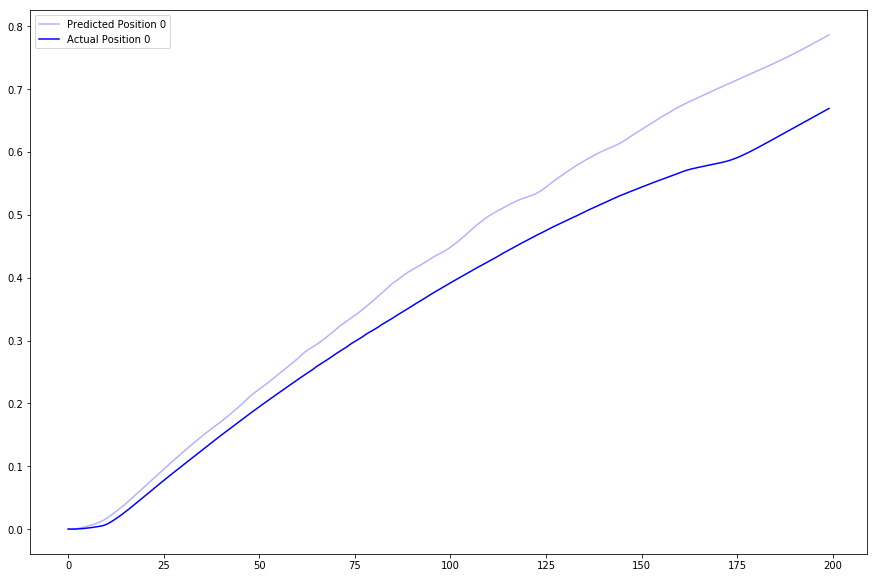

(1, 200, 2)
Position MSE:  0.0052365335


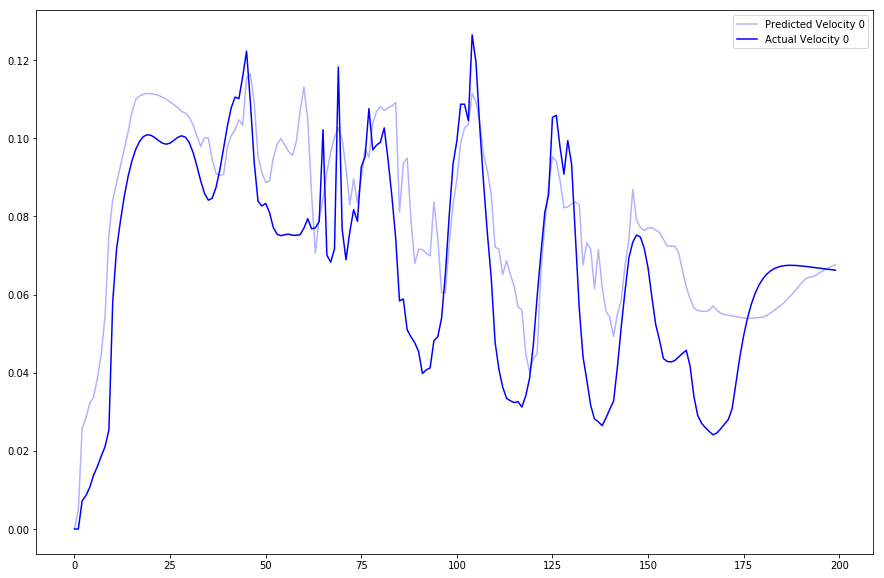

Velocity MSE:  0.00035805657


In [16]:
def vis_eval(predicted_states, actual_states):
    timesteps = len(actual_states[0])

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    
    plt.figure(figsize=(15,10))    
    for i, (pred, actual) in enumerate(zip(predicted_states, actual_states)):
        plt.plot(range(timesteps), pred[:,0], label="Predicted Position " + str(i), c=colors[i], alpha=0.3)
        plt.plot(range(timesteps), actual[:,0], label="Actual Position " + str(i), c=colors[i])
    plt.legend()
    plt.show()
    print(predicted_states.shape)
    print("Position MSE: ", np.mean((predicted_states[:,:,0] - actual_states[:,:,0])**2))

    plt.figure(figsize=(15,10))
    for i, (pred, actual) in enumerate(zip(predicted_states, actual_states)):
        plt.plot(range(timesteps), pred[:,1], label="Predicted Velocity " + str(i), c=colors[i], alpha=0.3)
        plt.plot(range(timesteps), actual[:,1], label="Actual Velocity " + str(i), c=colors[i])
    plt.legend()
    plt.show()
    print("Velocity MSE: ", np.mean((predicted_states[:,:,1] - actual_states[:,:,1])**2))

vis_eval(pred, actual)


Progress: [####################] 100.0%


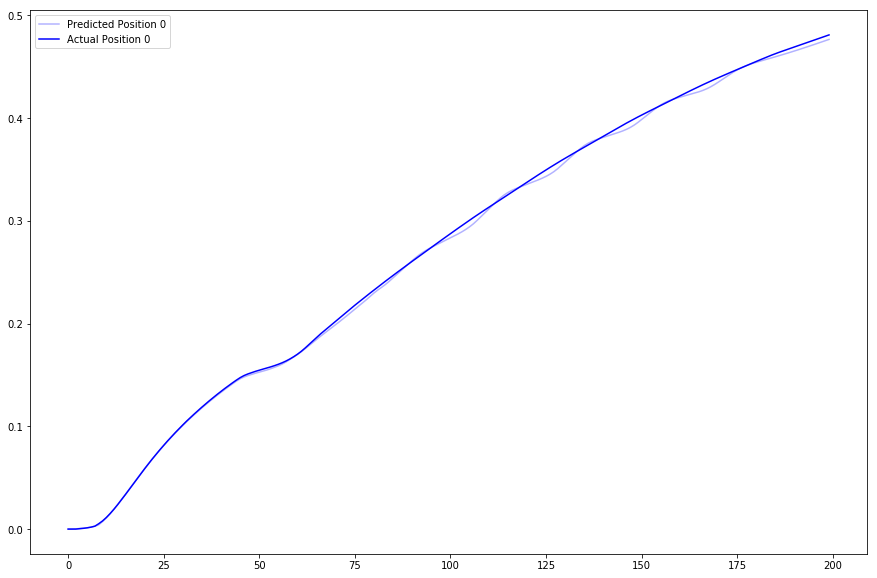

(1, 200, 2)
Position MSE:  8.241310053525441e-06


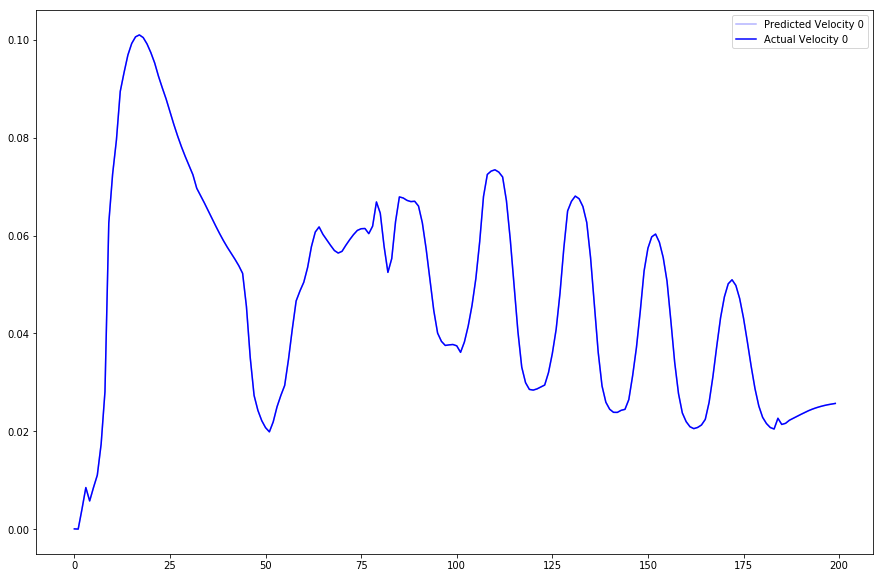

Velocity MSE:  0.0


In [29]:
### DEAD RECKONING TEST

# def eval(trajectories, max_timesteps=100000):
#     # To make things easier, we're going to cut all our trajectories to the same length :)
#     timesteps = np.min([len(s) for s, _, _ in trajectories] + [max_timesteps])
#     predicted_states = [[states[0]] for states, _, _ in trajectories]
#     actual_states = [states[:timesteps] for states, _, _ in trajectories]

#     for t in range(1, timesteps):
#         for i in range(len(trajectories)):
#             prev_state = predicted_states[i][t - 1]
#             new_vel = actual_states[i][t][1]
#             new_pos = prev_state[0] + new_vel / 20
            
#             predicted_states[i].append([new_pos, new_vel])
#         misc_utils.progress_bar(t / timesteps)
#     misc_utils.progress_bar(1.)

#     predicted_states = np.array(predicted_states)
#     actual_states = np.array(actual_states)
#     return predicted_states, actual_states


# eval_trajectories = file_utils.load_trajectories(
#     "data/pull-test-small.hdf5",   
#     use_proprioception=True,
#     use_vision=True,
#     vision_interval=1
# )
# pred, actual = eval(eval_trajectories[0:1], max_timesteps=200)
# vis_eval(pred, actual)
